# 无监督学习——多元分析

传统的多元分析包括：主成分分析、因子分子、聚类分析、典型相关分析、判别分析
由于**没有目标变量或者因变量**，多元分析是无监督学习。因此，多元分析没有一个诸如预测精度之类的优劣标准，任何文献中提出的所谓的标准都是对显示世界的数据做出主观假定后才发现的，不属于科学的范畴。
当多个指标阐释一个对象时，我们必须把多个指标的各个方面进行高度概括，用一两个指标简洁明了的说明白情况。在如此多的变量之中，我们希望找出他们的“少数代表”来对他们进行描述，也就是需要**降低变量的维数**。 

但是： 
 
->降维必定损失信息 
 
->如果数据之间相互独立，降维是不可能的

In [6]:
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import graphviz

# 用于创建一个具有默认值的字典
from collections import defaultdict
# 方便地在Jupyter Notebook或IPython环境中呈现和交互式操作SVG图像
from IPython.display import SVG

import statsmodels as tsm
import matplotlib as tplt
import sklearn as tsk

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram,linkage,set_link_color_palette
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr


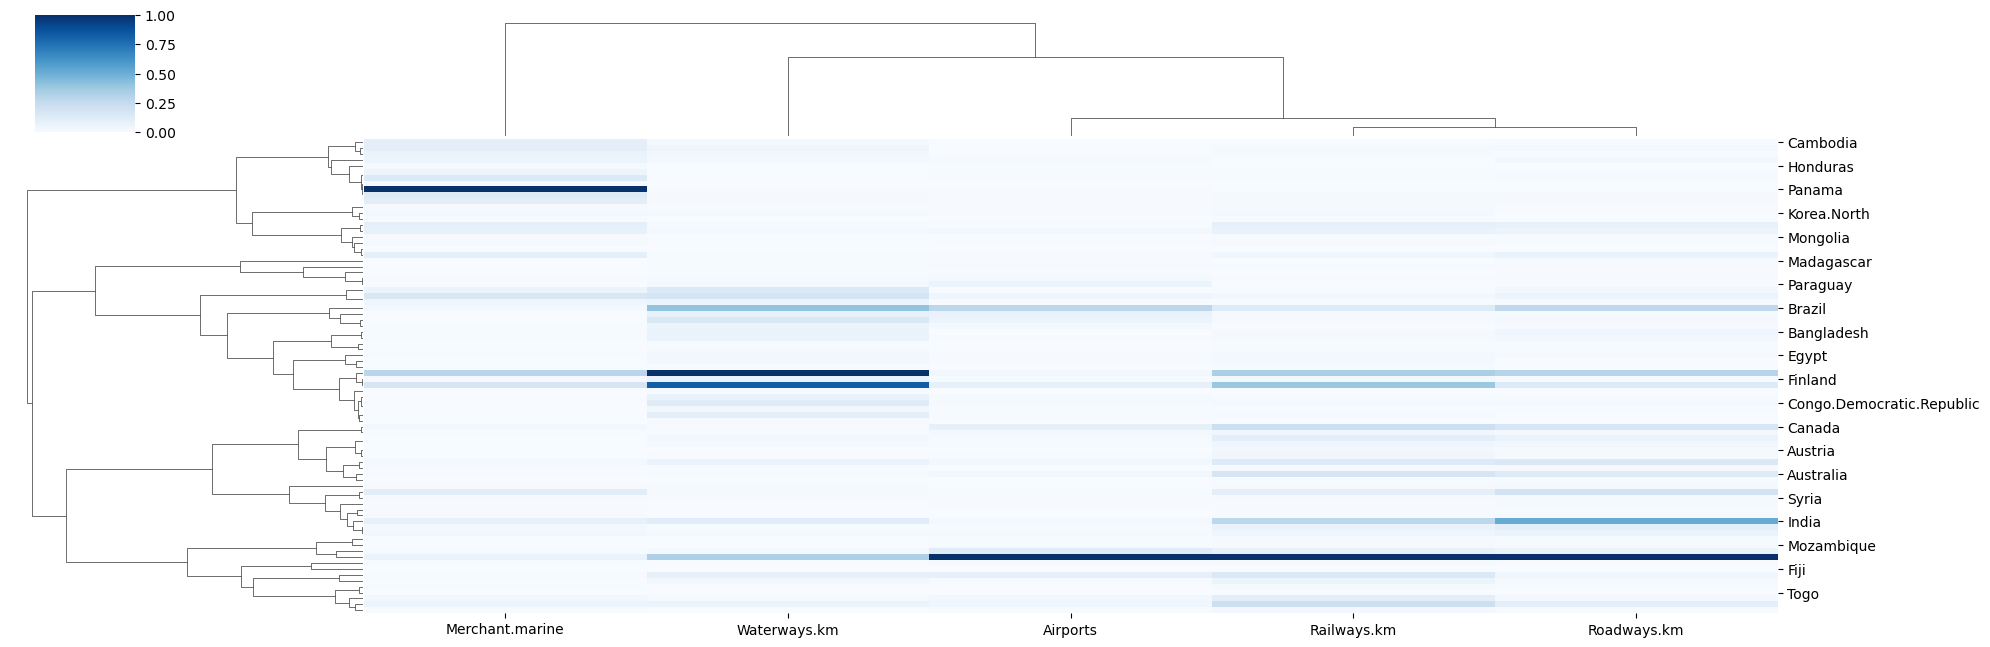

In [5]:
trans = pd.read_csv("../data/trans.txt",sep='\s+')
sns.clustermap(trans,metric="correlation",method="complete",cmap="Blues",figsize=(20,6.5),standard_scale=1)

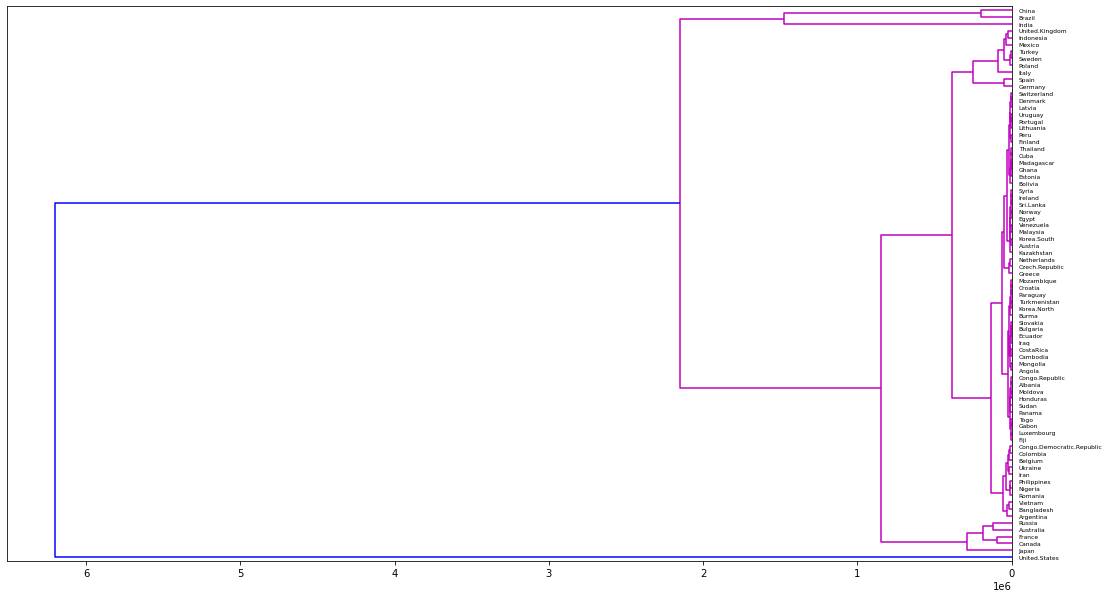

In [8]:
Z  =linkage(trans,method="average",metric='euclidean')
set_link_color_palette(['m','c','y','k'])
fig = plt.figure(figsize=(18,10),dpi=72)
dendrogram(Z,labels=trans.index,leaf_rotation=0,orientation="left",leaf_font_size=6,color_threshold=None,above_threshold_color='blue')
set_link_color_palette(None)